In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:

from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import (PiecewisePolynomial, 
                         InverseKinematics, 
                         Sphere, 
                         Rgba, 
                         RigidTransform, 
                         RotationMatrix, 
                         Solve,
                         MathematicalProgram,
                         RollPitchYaw,
                         Cylinder)
import time
import pydrake


In [3]:
from environments import get_environment_builder

plant_builder = get_environment_builder('7DOFBINS')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
# def get_ik_problem_solver(plant_ik, plant_context_ik, frames, collision_free= False):
#     def solve_ik_problem(poses, q0, collision_free = collision_free):
#         tries = 3
#         q_min = plant.GetPositionLowerLimits()
#         q_max = plant.GetPositionUpperLimits()
#         q_diff =  q_max-q_min
#         ik = InverseKinematics(plant_ik, plant_context_ik)
#         #GlobalInverseKinematics(plant_ik) #InverseKinematics(plant_ik, plant_context_ik)
    
#         for pose, f in zip(poses, frames):
#             ik.AddPositionConstraint(
#                 f,
#                 [0, 0.10, 0],
#                 plant_ik.world_frame(),
#                 pose.translation()-0.02,
#                 pose.translation()+0.02,
#             )
#             # ik.AddWorldPositionConstraint(plant.GetBodyByName('ur_tool0').index(), 
#             #                               pose.translation(),
#             #                               pose.translation()-0.05,
#             #                               pose.translation()+0.05)
#             # ik.AddOrientationConstraint(
#             #     f,
#             #     RotationMatrix(),
#             #     plant_ik.world_frame(),
#             #     pose.rotation(),
#             #     0.1,
#             # )
#         if collision_free:
#             ik.AddMinimumDistanceConstraint(0.001, 0.1)
#         prog = ik.get_mutable_prog()
#         q = ik.q()
#         prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
#         prog.SetInitialGuess(q, q0)
#         result = Solve(ik.prog())
#         if result.is_success():
#                 return result.GetSolution(q)
#         return None
#     return solve_ik_problem

def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    transl = tf.translation()+tf.rotation()@np.array([0,0.1,0])
    if show_body_frame is not None:
        show_body_frame(RigidTransform(tf.rotation(), transl))

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))

# ik = InverseKinematics(plant, plant_context)
# collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
# def eval_cons(q, c, tol):
#     return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
# col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
# col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
# col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)

In [5]:
show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_acutal', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'body',
                  show_body_frame=show_body_frame)

In [6]:
q = np.zeros(plant.num_positions())

sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q6', max=3.05433, min=-3.05433)

In [7]:
from task_space_seeding_utils import solve_ik_problem

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
#ik sliders 
show_ik_targets = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_targ', 
                          )

ik_solver = partial(solve_ik_problem, 
                    plant_ik = plant,
                    plant_context_ik = plant_context,
                    frames = [plant.GetFrameByName('body')],
                    offsets = [np.array([0,0.1,0])],
                    collision_free=False,
                    track_orientation=False)
sliders_ik = []
pos_min = np.array([-0.5,-0.5, 0.01, -np.pi,-np.pi, -np.pi])
pos_max = np.array([1.0,0.5, 1, np.pi,np.pi, np.pi])
names = ['x', 'y', 'z','rx', 'ry', 'rz']
q0 = np.zeros(7)#np.array([ 0.23294, -0.2944 , -0.36706, -1.5944 , -0.16706,  0.     ,
       # 1.64567])
_ik_positions = np.zeros(6)

for i in range(6):
    sliders_ik.append(widgets.FloatSlider(min=pos_min[i], 
                                       max=pos_max[i], 
                                       value=0.5*(pos_max[i]-pos_min[i])+pos_min[i], 
                                       description=names[i]))

def handle_slider_change_ik(change, idx):
    _ik_positions[idx] = change['new']
    rot = RotationMatrix.MakeXRotation(_ik_positions[3])@RotationMatrix.MakeYRotation(_ik_positions[4])@RotationMatrix.MakeZRotation(_ik_positions[5])

    RollPitchYaw(_ik_positions[3],
                       _ik_positions[4],
                       _ik_positions[5]).ToRotationMatrix()
    tf = RigidTransform(rot, _ik_positions[:3])
    show_ik_targets(tf)
    res = ik_solver([tf], q0)
    if res is not None:
        showres(res)

idx = 0
for slider in sliders_ik:
    slider.observe(partial(handle_slider_change_ik, idx = idx), names='value')
    idx+=1

for slider in sliders_ik:
    display(slider)

FloatSlider(value=0.25, description='x', max=1.0, min=-0.5)

FloatSlider(value=0.0, description='y', max=0.5, min=-0.5)

FloatSlider(value=0.505, description='z', max=1.0, min=0.01)

FloatSlider(value=0.0, description='rx', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='ry', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='rz', max=3.141592653589793, min=-3.141592653589793)

In [9]:
from visualization_utils import plot_points, plot_regions
from pydrake.all import VPolytope, Role
from task_space_seeding_utils import (get_cvx_hulls_of_bodies,
                                      get_AABB_cvxhull,
                                      task_space_sampler_mp,
                                      task_space_sampler)

In [10]:
#Determine task space regions of interest
from visibility_utils import generate_distinct_colors
geom_names = ['bin_base', 'bin_base', 'shelves_body']
model_names = ['binL', 'binR', 'shelves']
ts_samplers = []
cols = generate_distinct_colors(2*len(model_names), rgb = True)[2:]
#cols = [list(c)+[1] for c in cols]
for i, (g, m) in enumerate(zip(geom_names, model_names)):
    cvx_hulls_of_ROI, bodies = get_cvx_hulls_of_bodies([g], [m], plant, scene_graph, scene_graph_context)
    ts_min, ts_max, cvxh_hpoly = get_AABB_cvxhull(cvx_hulls_of_ROI)
    plot_regions(meshcat, cvx_hulls_of_ROI, region_suffix=m,opacity=0.2, colors=[cols[i]])
    q0  = np.zeros(7)
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("body")).translation()       
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['body'],
                            offsets = [np.array([0,0.1,0])],
                            cvx_hulls_of_ROI =cvx_hulls_of_ROI,
                            ts_min = ts_min,
                            ts_max = ts_max,
                            collision_free = True,
                            track_orientation = True,
                            )
    ts_samplers.append(sample_handle_ts)

In [11]:
from pydrake.all import SceneGraphCollisionChecker
from visibility_utils import vgraph
from clique_covers import compute_greedy_clique_partition

robot_instances = [plant.GetModelInstanceByName("iiwa"), plant.GetModelInstanceByName("wsg")]
checker = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
                    robot_model_instances = robot_instances,
                    distance_function_weights =  [1] * plant.num_positions(),
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.125)
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 

INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


In [12]:
import os
import pickle
Npts= 2000
if f"7dof_bin_sampl3_{Npts}.pkl" in os.listdir('tmp'):
    with open(f"tmp/7dof_bin_sampl3_{Npts}.pkl", 'rb') as f:
        d = pickle.load(f)
        q_obj = d['q_obj']
        t_obj = d['t_obj']
        ad_mat = d['ad_obj']
else:
    q_obj = []
    t_obj = []
    ad_obj = []
    for sh in ts_samplers:
        q, t, _, res = sh(Npts,[])
        ad_mat = vgraph_handle(q)
        q_obj +=[q]
        t_obj +=[t]
        ad_obj +=[ad_obj]
    with open(f"tmp/7dof_bin_sampl3_{Npts}.pkl", 'wb') as f:
        pickle.dump({'q_obj':q_obj, 't_obj':t_obj, 'ad_obj': ad_obj}, f)

[[100, 978], [100, 826], [100, 442], [100, 300], [100, 169], [100, 708], [100, 896], [100, 335], [100, 896], [100, 783], [100, 443], [100, 324], [100, 626], [100, 793], [100, 262], [100, 638], [100, 897], [100, 797], [100, 976], [100, 128]]


100%|██████████| 100/100 [04:17<00:00,  2.58s/it]


[[100, 949], [100, 112], [100, 865], [100, 337], [100, 208], [100, 57], [100, 121], [100, 152], [100, 84], [100, 338], [100, 883], [100, 226], [100, 161], [100, 451], [100, 582], [100, 646], [100, 113], [100, 100], [100, 79], [100, 464]]


100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


[[100, 815], [100, 877], [100, 296], [100, 764], [100, 132], [100, 30], [100, 284], [100, 222], [100, 367], [100, 259], [100, 754], [100, 98], [100, 331], [100, 300], [100, 470], [100, 189], [100, 678], [100, 842], [100, 177], [100, 182]]


100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


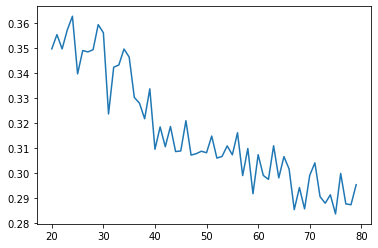

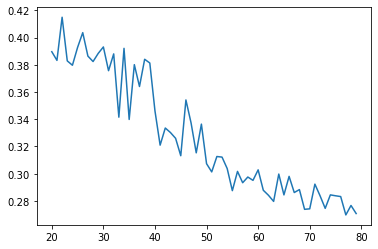

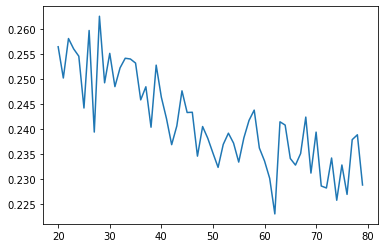

In [13]:
#cluster points
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
cliques_obj = []
for q, t in zip(q_obj, t_obj):
    sil = []
    kmsol = []
    clus_vals = np.arange(20,80)
    for k in clus_vals:
        #print(k)
        km = KMeans(n_clusters=k).fit(q)
        kmsol.append(km)
        labels = km.labels_
        sil.append(silhouette_score(q, labels, metric='euclidean'))

    fig = plt.figure()
    plt.plot(clus_vals,sil)

    best_clustering = kmsol[np.argmax(sil)]
    num_clusters = clus_vals[np.argmax(sil)]
    q_clus = [q[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    t_clus = [t[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    idx_clus = [np.where(best_clustering.labels_ == l )[0] for l in range(num_clusters)]
    vgraph_clus = [vgraph_handle(qc) for qc in q_clus]
    cliques_cluster = []
    for ad in vgraph_clus:
        smin =5
        cliques = compute_greedy_clique_partition(ad.toarray(), min_cliuqe_size=smin)
        cl = []
        for c in cliques:
            if len(c)>=smin:
               cl.append(c)
        cliques_cluster.append(cl)
    cliques_clusters_glob = []
    for clus_idx, cliques in enumerate(cliques_cluster):
        for c in cliques:
            if len(c):
                cliques_clusters_glob.append(idx_clus[clus_idx][c])
    cliques_obj.append(cliques_clusters_glob)

In [16]:
t_tot = np.concatenate(tuple(t_obj), axis=0)
q_tot = np.concatenate(tuple(q_obj))
cliques_tot = []
offset = 0
for i, c in enumerate(cliques_obj):
    if i>0:
        offset+= len(q_obj[i-1])
    cliques_tot += [cl + offset for cl in c] 
#plot_points(meshcat, t_tot, 'allsamp', size=0.005)

In [17]:
from visibility_utils import generate_distinct_colors
cols = generate_distinct_colors(len(cliques_tot)+5, rgb = True)[5:]
cols = [list(c)+[1] for c in cols]

for id, c in enumerate(cliques_tot):
    plot_points(meshcat, t_tot[c], f"ct{id}", size = 0.01, color=Rgba(*cols[id]))
for idx in range(len(cliques_tot)):
        meshcat.SetProperty(f"/drake/ct{idx}", "visible", True)
print(len(cliques_tot))

263


In [18]:
def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName('body'))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [19]:
clique_idx = 0
for clique_idx in range(len(cliques_tot)):
    for idx in range(len(cliques_tot)):
        meshcat.SetProperty(f"/drake/ct{idx}", "visible", False)
    meshcat.SetProperty(f"/drake/ct{clique_idx}", "visible", True)
        
    cliques_vis = cliques_tot[clique_idx]
    start = q_tot[cliques_vis[0]]
    target = q_tot[cliques_vis[np.random.randint(len(cliques_vis))]]
    showres(target)
    for i in range(3):
        wpd = densify_waypoints([start, target], 50)
        #print(f"norm {np.linalg.norm(start-target)}")
        plot_endeff_traj(wpd, 'p', cols[clique_idx])
        for qa in wpd:
            showres(qa)
            #diagram_context.SetTime(cur_time)
            # if col_func_handle(qa):
            #     print('col')
            # cur_time+=frame_time
            time.sleep(0.02)
        meshcat.Delete('/iris/points/traj')
        start = target
        target = q_tot[cliques_vis[np.random.randint(len(cliques_vis))]]

In [20]:
from visibility_utils import get_coverage_estimator, get_sample_cfree_handle, get_col_func
from clique_covers import get_iris_metrics
from region_generation import SNOPT_IRIS_ellipsoid_parallel

q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1
col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 100
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_snopt_seed_guesses = 100
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = None, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)

In [21]:
if f"regions_clus4_{Npts}.pkl" in os.listdir('tmp'):
    with open(f"tmp/regions_clus4_{Npts}.pkl", 'rb') as f:
        regions_red = pickle.load(f)
else:
    def col_hnd(pt):
        return 1- 1.0*checker.CheckConfigCollisionFree(pt)
    seed_points, metrics, _ = get_iris_metrics([q_tot[c] for c in cliques_tot], col_hnd)
    regions_red, succs_sp, is_full = iris_handle(seed_points, metrics, [])
    with open(f"tmp/regions_clus4_{Npts}.pkl", 'wb') as f:
        pickle.dump(regions_red, f)

[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRIC] ELLIPSOID COMPUTATION FAILED
[IRIS METRI

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.02551383  0.85510571 -0.08225361 -1.2155213   0.66435648 -0.52461671
  0.08220066]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.09455818  1.38085846  1.81874185  1.59628869  1.90504667 -1.48241431
  0.05896753]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against table::table_top has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-0.21594387  0.79593105  0.17389528 -1.40870087 -0.97870862 -0.96008896
 -1.32329865]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.85963472  1.19014359  2.21616961  1.3193317   0.09626433 -1.2515834
 -1.95134128]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking wsg::collision against table::table_top after 1417 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 2.06230787 -1.15959344 -0.95520163  1.09545952 -2.53073247  1.40199
 -0.43363105]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binR::bottom has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-0.6537155  -1.39893597  1.70884757 -1.41995436  0.50552288  0.77640102
  1.02963967]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against binL::back has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against binL::back after 1378 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-1.02341728  0.80696323  2.60105228  1.67380593  2.29553685  0.52892637
 -2.14686736]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.89595524  1.07877764  1.63755241 -1.11478109  0.14444747  0.72403557
 -1.73285585]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.21550631  1.50190402  0.28103859 -0.76486748  1.3927565   1.37416012
  2.50853196]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.34005747 -0.68805665  1.18129663  1.73043646 -1.87544193 -1.11815522
  2.0253886 ]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::back has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [ 0.34362397  1.04377137 -0.30921982 -1.61673648  0.83762855 -0.60624757
  0.86113039]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking wsg::collision against binL::back after 1096 counter-example searches.
INFO:drake: Checking iiwa::iiwa_link_4_collision against binL::back has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_4_collision against binL::back after 1062 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-0.03186457  0.60660301  0.43117781 -1.43018922  0.05875347 -1.26562122
  1.16243889]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.20603153 -1.07235905  1.29292919 -1.52847108 -0.67093635  0.21148715
 -0.89835361]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.25987518e+00 -1.46447867e+00  1.98876813e+00 -1.46691303e+00
 -3.24673723e-04  3.08278251e-01 -6.67299267e-01]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-1.66222089  0.9532251  -0.1994221  -1.48810801 -1.77046457 -1.25526647
 -1.33227335]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.54969613  1.63354654  1.11035509 -0.93087832  0.32169646  0.75506904
 -1.85829294]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.67150524  0.63888378  0.70612717 -0.76652725  0.47460867  1.15849374
 -0.89731881]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.89663808  1.19306862  1.38801078 -1.48080334 -0.55411954  0.23289362
 -1.60842183]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.93956465  1.57496279 -1.89467421  1.50166876  2.48661594 -0.02522821
  2.63513969]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.82352235  1.56036564  1.3119939  -1.46720668 -0.39465519  0.4154079
 -2.21693696]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.17035345 -1.27263565 -1.70230286 -1.47402328  0.31348143  0.56266415
  0.67593776]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.23108383 -0.90112541 -1.5017362  -1.27978122 -0.10268506  0.33359837
  0.53306773]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.38589002 -1.20743106 -2.23781459 -1.52252192  0.22899447  0.14281597
  0.41386229]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.88553498  1.49567631 -2.1921302   1.21672226  0.73723421 -0.78867868
 -1.58220978]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.26500276 -0.46561542 -0.99845024  1.29053553  0.30341589 -0.09111851
  0.14370755]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.6670772   1.59452113 -1.71233989  2.0142779  -0.34631028 -0.91148579
 -0.79752251]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.54755522 -1.35759914 -1.71711924 -1.80363543 -1.76490065  0.99927917
  0.96797955]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:0 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.2506044  -0.9664133  -2.18874412 -1.21569891 -1.31792437  1.05218941
  1.18289921]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [ 2.55529315  1.49802196  1.62480562  1.7951829  -1.34264232  1.00705188
 -2.21770274]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.17906003  0.34396884 -0.02315403 -1.33547342 -1.81732027  0.6519344
  0.76237248]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.06801727  1.34286578 -1.54089073 -1.36760633  0.21890225  0.47206889
  2.09826781]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision after 1893 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 0.53500179  1.28679727 -1.89695935  1.64526638 -0.27721942 -0.35529365
 -0.48786614]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:7 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against binL::back has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against binL::back after 1142 counter-example searches.


[SNOPT IRIS Worker]: Region:1 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.72889416  1.03552226  0.84207927 -1.77990631  2.10110245  0.36901321
  1.88261044]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.39972327  1.20519747  0.52992004 -1.25881344  1.42390794 -1.436757
  0.8587374 ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binR::back has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::back after 1093 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision has already required 1000 counter-example searches; still searching...
INFO:drake: Checking wsg::collision against shelves::shelf_lower has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-0.79049103  0.94956793  2.47145062  1.45822325  2.68253342  0.80310816
  1.56417013]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking wsg::collision against shelves::shelf_lower after 1783 counter-example searches.
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision after 2324 counter-example searches.
INFO:drake: Checking iiwa::iiwa_link_5_collision against table::table_top has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:1 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-1.83928073  0.46255404 -2.30236825  1.12244809 -1.34426271 -0.89126753
  1.82159557]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.13443525 -0.71136435 -2.78824588 -1.73016601 -2.48521968  0.08507854
 -2.72478088]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.58106904  1.98321264  1.30501388  0.92611766  0.56108968 -0.66199253
  1.59681682]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against shelves::shelf_upper has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [ 0.77247452  1.39648265  1.02134005  1.1461024   0.75687348 -0.5634302
  0.35751811]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_7_collision against shelves::shelf_lower has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_7_collision against shelves::shelf_lower after 1105 counter-example searches.


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.82233175  1.44418568  2.00332346  1.42674943  0.67538914 -0.08056697
  0.78903655]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.7986216   1.20011305  1.63562488  1.40594926  0.16892536 -0.62209431
  0.2845308 ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.63191244  1.83641348  1.65823447  1.0725714   0.69340691  0.05783866
 -0.05608133]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::front has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binL::front after 1089 counter-example searches.


[SNOPT IRIS Worker]: Region:1 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.14074434  0.83024376 -0.00902659 -1.29711153 -1.17109628 -1.10796052
  0.28034395]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.93750762 -0.73051316 -0.5893758   1.8175972  -1.2728747  -0.04499156
 -0.89004947]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.56773792  0.63339344  0.69054103 -1.13133029 -1.66314155 -0.92037562
 -0.29007447]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.48533753  1.68916895  1.06305724 -0.77078152 -2.39525782 -1.01758036
 -0.3674122 ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.34148029  1.31014933  0.26568733 -1.20019687 -1.29964384 -1.11010225
  0.35503548]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-1.79686104 -0.93665352  0.1206554   1.51926722 -1.93115493  1.11998966
 -1.59532994]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::front has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-1.92497612 -1.25233988 -1.71071663 -1.11793187 -0.61410123  1.59886174
 -1.37174927]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:2 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.95423962 -0.8588923   0.53511033  1.54381955  0.65682514 -0.66647759
 -1.55715906]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:7 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.82813227 -1.03555818  2.96706    -1.14936938  2.72554538 -1.52728662
 -2.08992666]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.68945527 -1.24012034  2.13371637 -1.02067923  1.00074646  1.52244131
 -0.15527895]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_7_collision against shelves::shelf_lower has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-0.69599986  1.46407484 -1.56229721  1.26734133 -0.47117934 -0.12731356
 -0.33541376]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against shelves::right_wall has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::right_wall after 1171 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-0.90062262  1.42435127 -1.05430694  1.24600318 -0.35613484 -0.49730397
 -0.51146133]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.80831076  1.34916119 -1.62403455  1.31879354 -0.13174006 -0.27193706
 -0.43458626]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.48924137  1.18746381 -1.39175958  1.46122926  0.0902766   1.15026934
  0.16225511]!
[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.83605759  1.17815855 -1.34132343 -1.8432655   1.94773871  1.48140938
 -2.05896735]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::front has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker] Region failed at [-1.04218843 -0.752246   -0.45529464  1.45099631  0.27603196 -0.26975419
  0.32258154]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-1.5112912  -0.84473163 -0.11696048  1.44643073  0.58039218 -0.79716431
  1.47642   ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.24943893  1.13592469  0.96113454 -1.56427842 -0.48517914  0.45350761
 -2.42205112]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:3 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.29614391 -1.11475914  1.94997194 -1.69092288 -0.16133308  0.27233337
  0.33672923]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.59460641 -0.72237207 -0.14137524  1.54071796  0.14982757 -0.81734467
  1.48430319]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:4 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.89675392 -1.35071975 -0.42825678  1.05206517 -0.97698682 -1.37906689
  2.66589616]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.21480342 -1.37900338 -2.16999491 -1.4908764  -1.04616551 -0.35455498
 -1.86502803]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::left has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:7 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.11565399  1.02170118 -0.71228915 -1.38544431  0.05551796  0.74071116
  1.64407335]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:7 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.81176522  0.74240826  2.68542893  1.90864631 -0.52881368  0.77858897
  1.74700198]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.12826659  0.86827381 -0.19039774 -1.21686225  0.02343541 -0.50819821
 -0.70133409]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.12791862  0.55244149  0.32003299 -1.04443185 -0.32132843  0.11937436
 -0.48556321]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:8 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against shelves::right_wall has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::right_wall after 1053 counter-example searches.
INFO:drake: Checking iiwa::iiwa_link_6_collision against shelves::shelf_lower has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_6_collision against shelves::shelf_lower after 1320 counter-example searches.


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.74136519 -0.9241238   0.0616956   1.3595243   1.93669116  1.36343951
  1.63517853]!
[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:6 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-1.15614173  1.0532831   2.19289605  1.43388442 -1.98496353  1.1621706
 -0.79266223]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:7 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:5 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_6_collision against binR::left has already required 1000 counter-example searches; still searching...
INFO:drake: Checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision after 1540 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 0.10343886  0.61357645 -0.61442695 -1.16834579  2.07053419  1.08247925
 -2.42215791]!
[SNOPT IRIS Worker] Region failed at [-1.20445013  0.91389531 -0.3673665  -1.23801491  0.35266093  0.93450272
  0.99406481]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-2.30341013 -1.18168009  0.95099518  1.5390379   0.04393176 -0.91565589
 -2.31550334]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:6 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision after 2989 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 1.69319579 -1.04138431  2.5251658  -1.25976333 -2.02794996 -1.47162567
  1.54270019]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against table::table_top has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:7 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_6_collision against binR::right has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against table::table_top after 1875 counter-example searches.


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_6_collision against binL::front has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_6_collision against binR::right after 2620 counter-example searches.
INFO:drake: Finished checking iiwa::iiwa_link_6_collision against binL::front after 1294 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-1.59278744e+00 -6.88774191e-01  1.56521042e-04  1.77992169e+00
  1.60077008e+00 -3.39949515e-01 -1.38937580e+00]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_6_collision against binR::front has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:7 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_7_collision against binL::back has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:10 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.5535914   1.46299711 -1.45610378 -1.61176586 -2.2294117  -0.73421633
 -1.0424629 ]!


INFO:drake: Finished checking iiwa::iiwa_link_7_collision against binL::back after 1192 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 1.13356178  0.9572477  -2.42554187  1.39551752 -0.57752188 -1.09228819
  2.27848624]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against binR::front has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker]: Region:6 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against binR::front after 1492 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-0.97898892  0.93632504 -0.48346151 -1.62139999  1.8213234  -0.61366715
 -0.68103549]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against table::table_top has already required 1000 counter-example searches; still searching...


[SNOPT IRIS Worker] Region failed at [-0.89530834 -1.20756549  2.06450383 -1.2841265   0.28135377  1.16916638
 -1.13252331]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.79204446 -0.83641905  2.25801612 -1.45714771  1.28797555  0.85916333
 -1.64699511]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [-0.80367752  1.29295504  1.69686105  1.27735734  0.66571235 -1.04425179
  0.4666331 ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.0598732   0.98208661 -0.60176041 -1.19056266 -0.73565925 -1.16918875
 -0.6887645 ]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 0.18126467  1.37627158 -0.47000881 -1.18516111 -0.55555914 -1.26533808
 -0.68989061]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:8 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:7 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 13


INFO:drake: Checking iiwa::iiwa_link_5_collision against binL::front has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against binL::front after 2092 counter-example searches.


[SNOPT IRIS Worker]: Region:12 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [2.28861676 0.71443069 2.6711198  1.52050854 1.66564187 0.31454313
 0.42652333]!
[SNOPT IRIS Worker] Region failed at [ 0.90308128  1.52077834 -1.66101242  0.95564687 -0.61748427 -1.51196578
 -2.05716004]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:12 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:9 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:13 / 14
[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.29387572  0.71099292  0.16139302 -1.55189404 -0.34863166  0.32044604
 -0.02689036]!


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 1.46046425  1.10221693  0.01258685 -1.36125137 -1.90415534 -1.51028985
 -0.52098876]!
[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker] Region failed at [ 2.20253516 -0.91417983  1.83808095 -1.75026399  0.75045269  1.56694168
  2.23321969]!
[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:9 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:11 / 13


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:10 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 13
[SNOPT IRIS Worker]: Region:11 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::front has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binL::front after 1244 counter-example searches.
INFO:drake: Checking iiwa::iiwa_link_6_collision against binL::right has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_6_collision against binL::right after 1274 counter-example searches.


[SNOPT IRIS Worker] Region failed at [ 1.47936523  0.61676149 -0.03485486 -1.88340821  1.83307464  0.49762029
 -2.05030945]!


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binL::back has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binL::back after 1028 counter-example searches.


[SNOPT IRIS Worker]: Region:11 / 14


INFO:drake:IrisInConfigurationSpace iteration 0


[SNOPT IRIS Worker]: Region:12 / 14


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::iiwa_link_5_collision against iiwa::iiwa_link_7_collision after 1991 counter-example searches.


[SNOPT IRIS Worker] Region failed at [-0.91880192 -1.32624361  1.91201378 -1.2407937   0.86804032  1.07931654
  1.37382076]!
[SNOPT IRIS Worker]: Region:13 / 14


In [56]:
with open('seed_data.pkl', 'wb') as f:
    pickle.dump({'seed_points': seed_points, 'ellipsoids': metrics, 'cliques': [q_tot[c] for c in cliques_tot], 'tasksp_cliques':[t_tot[c] for c in cliques_tot], 'regs_crit': r_coll}, f)


In [22]:
from pydrake.all import RandomGenerator
gen = RandomGenerator(4)
Ns = 10000
s_reg = []
for r in regions_red:
    samps = []
    for _ in range(Ns):
        if len(samps):
            samps.append(r.UniformSample(gen, samps[-1]))
        else:
            
            samps.append(r.UniformSample(gen))
    s_reg.append(samps)

frac_vol_in_collision = []
for s in s_reg:
    tot_col = 0
    for pt in s:
        if not checker.CheckConfigCollisionFree(pt):
            tot_col+=1
    frac_vol_in_collision.append(tot_col/Ns)

print(frac_vol_in_collision)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8378, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.8819, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0326, 0.0, 0.001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0053, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3628, 0.3203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5344]


(array([ 13,  69, 109, 123, 141, 142, 148]),)

In [42]:
idx = np.where(np.array(frac_vol_in_collision)>=0.1)[0]
succs_sp = [ s[0] for s in succs_sp]
r_coll = [regions_red[i] for i in idx]

In [52]:
index_glob = []
for pt in np.array(succs_sp)[idx]:
    index_glob.append(np.where(pt[0] == np.array(seed_points)[:,0])[0])

In [54]:
index_glob = [ i.item() for i in index_glob]

In [55]:
index_glob

[18, 100, 166, 191, 224, 227, 238]

len(frac_

In [21]:
from pydrake.all import RandomGenerator
gen = RandomGenerator(43234)
Ns = 10000
s_reg = []
for r in regions_red:
    samps = []
    for _ in range(Ns):
        if len(samps):
            samps.append(r.UniformSample(gen, samps[-1]))
        else:
            
            samps.append(r.UniformSample(gen))
    s_reg.append(samps)

frac_vol_in_collision = []
for s in s_reg:
    tot_col = 0
    for pt in s:
        if not checker.CheckConfigCollisionFree(pt):
            tot_col+=1
    frac_vol_in_collision.append(tot_col/Ns)

print(frac_vol_in_collision)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4143, 0.0, 0.0, 0.0, 0.0, 0.503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0085, 0.0, 0.0, 0.0033, 0.0, 0.0, 0.0, 0.0, 0.8384, 0.0, 0.5984, 0.0, 0.0, 0.0, 0.0, 0.0004, 0.0002, 0.0, 0.0064, 0.0, 0.2199, 0.118, 0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.749, 0.2196, 0.0]


In [34]:
sizes = [r.A().shape[0] for r in regions_red]
idxs = np.argsort(sizes)
np.array(frac_vol_in_collision)[idxs]

array([2.654e-01, 7.005e-01, 3.329e-01, 7.472e-01, 4.097e-01, 6.554e-01,
       4.680e-01, 3.647e-01, 2.009e-01, 2.240e-02, 1.000e-04, 0.000e+00,
       4.000e-04, 1.000e-03, 3.000e-04, 4.000e-04, 0.000e+00, 1.400e-03,
       0.000e+00, 0.000e+00, 0.000e+00, 2.800e-03, 3.200e-03, 4.700e-02,
       1.700e-03, 3.000e-04, 0.000e+00, 9.800e-03, 9.000e-04, 1.010e-02,
       0.000e+00, 0.000e+00, 1.300e-03, 3.200e-03, 2.000e-02, 7.300e-03,
       0.000e+00, 0.000e+00, 0.000e+00, 2.400e-03, 4.800e-03, 7.000e-04,
       1.190e-02, 9.000e-04, 0.000e+00, 1.000e-04, 5.000e-04, 0.000e+00,
       6.000e-04, 8.000e-04, 9.300e-03, 3.000e-04, 0.000e+00, 1.000e-04,
       0.000e+00, 0.000e+00, 4.000e-04, 0.000e+00, 0.000e+00, 2.100e-03,
       1.000e-04, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 1.000e-04,
       2.000e-04, 0.000e+00, 8.000e-04, 2.000e-04, 1.000e-04, 3.600e-01,
       9.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00,
       5.710e-01, 7.400e-01])

In [42]:
print(frac_vol_in_collision[19])
print(regions_red[19].A().shape)

0.74
(337, 7)


In [29]:
regions_red[-5].A().shape

(49, 7)

In [23]:
from utils import load_regions_from_experiment_dir

regions_c = load_regions_from_experiment_dir(
                    'logs/experiment_7dof_iiwa_bins_taskspace_1_1500_0.400greedy20231024205238')
regions = regions_c+regions_red 

Text(0.5, 1.0, 'connectivity')

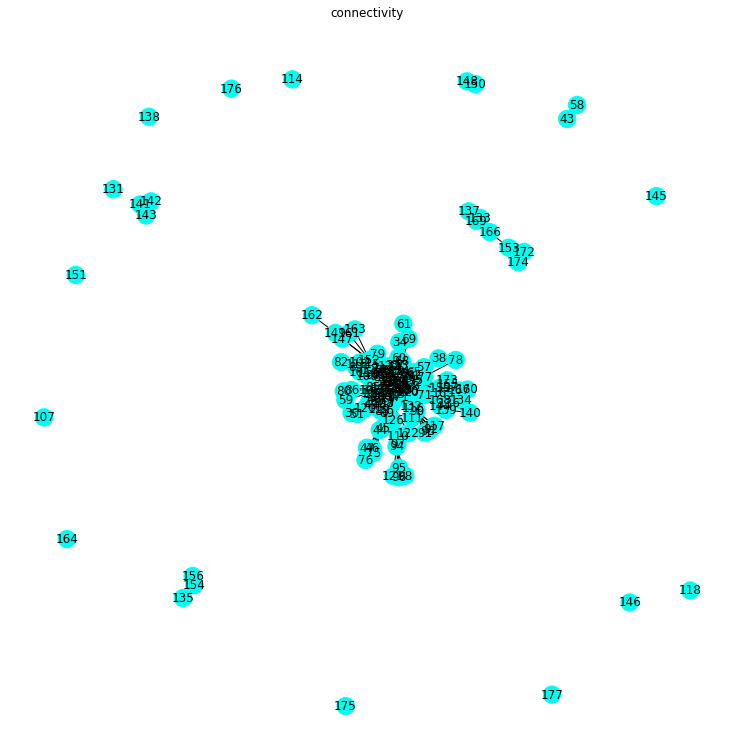

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

regs = regions
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [26]:
volumes = [r.MaximumVolumeInscribedEllipsoid().Volume() for r in regions]

(array([152.,   3.,   6.,   5.,   4.,   1.,   2.,   1.,   2.,   2.]),
 array([1.50796139e-07, 1.22996056e+02, 2.45992112e+02, 3.68988168e+02,
        4.91984224e+02, 6.14980280e+02, 7.37976336e+02, 8.60972393e+02,
        9.83968449e+02, 1.10696450e+03, 1.22996056e+03]),
 <a list of 10 Patch objects>)

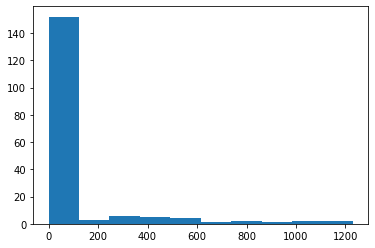

In [27]:
plt.hist(volumes)

In [30]:
volumes[len(regions_red):]

[0.00035765845891878764,
 5.513278390338719e-06,
 1.0495504193692355e-06,
 0.00011080553623775562,
 0.005718603080049145,
 0.004211949440745282,
 0.003102182352220558,
 7.363470615345496e-05,
 4.426131401942516e-05,
 0.00037646546498924213,
 0.002323271175707563,
 0.00015562384376859994,
 0.0002849375877712512,
 0.00030473979870064284,
 8.581102445690782e-05,
 8.018091897296722e-07,
 0.012713863724298518,
 0.0013866927589055596,
 0.0006216674395701125,
 0.00022156825758984217,
 1.0921777079699938e-06,
 0.004106155412125959,
 0.004243247160320456,
 8.906340063459143e-07,
 0.00027721626675436805,
 7.193106308697508e-06,
 1.5079613891952258e-07,
 0.0004389012868624128,
 0.00010942567029776661]

In [26]:
from visibility_utils import point_in_regions
inreg = []
inreg_q = []
for tpt, pt in zip(t_tot,q_tot):
    if point_in_regions(pt, regions):
        inreg.append(tpt)
        inreg_q.append(pt)
plot_points(meshcat, np.array(inreg), 'inregions', size = 0.01, color = Rgba(0,1,0,1))

In [24]:
from dijkstraspp import DijkstraSPPsolver
def dm(q):
    return q
dspp = DijkstraSPPsolver(regions_connected_component, dm)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 96
[DijkstraSPP] Pre-Building adjacency matrix  10 / 96
[DijkstraSPP] Pre-Building adjacency matrix  20 / 96
[DijkstraSPP] Pre-Building adjacency matrix  30 / 96
[DijkstraSPP] Pre-Building adjacency matrix  40 / 96
[DijkstraSPP] Pre-Building adjacency matrix  50 / 96
[DijkstraSPP] Pre-Building adjacency matrix  60 / 96
[DijkstraSPP] Pre-Building adjacency matrix  70 / 96
[DijkstraSPP] Pre-Building adjacency matrix  80 / 96
[DijkstraSPP] Pre-Building adjacency matrix  90 / 96
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 957


In [27]:
import time
from visibility_utils import point_in_regions
centers = [r.ChebyshevCenter() for r in regions_connected_component]
# meshcat.SetProperty(f"/Grid", "visible", False)
# meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)

np.random.seed(10)
start = centers[1]
cur_time = 0
for _ in range(150):
    #nxt = vs.sample_in_regions() #
    #while True:
    nxt = inreg_q[np.random.choice(len(inreg_q))]#sample_cfree(1, 1000, [])[0]
        # if point_in_regions(nxt_, regions_connected_component[9:]):
        #     nxt = nxt_.squeeze()
        #     break
        # nxt = centers[np.random.choice(len(centers))] #sample_cfree(1, 1000, [])[0].reshape(-1,1)#
        # #plot_endeff_pose(nxt, str(0))
        # if nxt.squeeze()[0] != start.squeeze()[0]:
        #     break
    #print(f"start {start} next {nxt}")

    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    #print(dist)
    meshcat.Delete("/iris/points/traj/")
    #if dist >0:
    dense_waypoints = densify_waypoints(wp, densify=50)
    dense_waypoints_plt = densify_waypoints(wp, densify=30)
    plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        #anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        #diagram_context.SetTime(cur_time)
        if not checker.CheckConfigCollisionFree(qa):
            print('col')
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        #frame+=1
        time.sleep(0.005)
    start = nxt.copy()
    time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")


[DijkstraSPP] optimized distance/ start-distance = 4.40 / 4.83 = 0.91
96
[DijkstraSPP] optimized distance/ start-distance = 7.38 / 10.69 = 0.69
164
[DijkstraSPP] optimized distance/ start-distance = 6.87 / 9.17 = 0.75
127
col
col
col
col
col
col
col
col
col
col
col
[DijkstraSPP] optimized distance/ start-distance = 7.18 / 8.67 = 0.83
155
[DijkstraSPP] optimized distance/ start-distance = 0.53 / 0.53 = 1.00
14
[DijkstraSPP] optimized distance/ start-distance = 4.72 / 6.57 = 0.72
123
[DijkstraSPP] optimized distance/ start-distance = 3.93 / 5.13 = 0.77
50
[DijkstraSPP] optimized distance/ start-distance = 5.71 / 10.84 = 0.53
173
col
col
[DijkstraSPP] optimized distance/ start-distance = 4.29 / 8.48 = 0.51
67
[DijkstraSPP] optimized distance/ start-distance = 3.45 / 4.90 = 0.71
35
[DijkstraSPP] optimized distance/ start-distance = 4.79 / 6.31 = 0.76
165
[DijkstraSPP] optimized distance/ start-distance = 4.36 / 5.21 = 0.84
120
col
col
col
col
col
col
col
col
col
col
[DijkstraSPP] optimized

In [32]:
RandomGenerator(3)

In [35]:
len(regions_red)

67

In [40]:
from pydrake.all import RandomGenerator
gen = RandomGenerator(4)
Ns = 10000
s_reg = []
for r in regions_red:
    samps = []
    for _ in range(Ns):
        if len(samps):
            samps.append(r.UniformSample(gen, samps[-1]))
        else:
            
            samps.append(r.UniformSample(gen))
    s_reg.append(samps)

frac_vol_in_collision = []
for s in s_reg:
    tot_col = 0
    for pt in s:
        if not checker.CheckConfigCollisionFree(pt):
            tot_col+=1
    frac_vol_in_collision.append(tot_col/Ns)

In [41]:
frac_vol_in_collision

[0.0034,
 0.0052,
 0.0,
 0.6628,
 0.0,
 0.2463,
 0.0019,
 0.0012,
 0.0006,
 0.0,
 0.5147,
 0.0,
 0.9858,
 0.0,
 0.0,
 0.3574,
 0.0002,
 0.0,
 0.5887,
 0.0002,
 0.0003,
 0.0004,
 0.0,
 0.0005,
 0.0,
 0.0014,
 0.4302,
 0.0,
 0.1426,
 0.0,
 0.0001,
 0.0,
 0.0,
 0.0015,
 0.0686,
 0.2216,
 0.0,
 0.0,
 0.0,
 0.0005,
 0.3266,
 0.0,
 0.0001,
 0.0018,
 0.0032,
 0.0,
 0.0131,
 0.2385,
 0.0005,
 0.0115,
 0.0,
 0.0003,
 0.2041,
 0.0004,
 0.0211,
 0.4811,
 0.1709,
 0.2005,
 0.0,
 0.0358,
 0.0172,
 0.4748,
 0.0067,
 0.0022,
 0.0021,
 1.0,
 0.4247]

In [42]:
from pydrake.all import RandomGenerator
gen = RandomGenerator(33412)
Ns = 10000
s_reg = []
for r in regions_red:
    samps = []
    for _ in range(Ns):
        if len(samps):
            samps.append(r.UniformSample(gen, samps[-1]))
        else:
            
            samps.append(r.UniformSample(gen))
    s_reg.append(samps)

frac_vol_in_collision = []
for s in s_reg:
    tot_col = 0
    for pt in s:
        if not checker.CheckConfigCollisionFree(pt):
            tot_col+=1
    frac_vol_in_collision.append(tot_col/Ns)

In [43]:
frac_vol_in_collision

[0.0005,
 0.0054,
 0.0017,
 0.6638,
 0.0002,
 0.4913,
 0.0042,
 0.0001,
 0.0004,
 0.0,
 0.5063,
 0.0,
 0.8347,
 0.0002,
 0.0,
 0.6147,
 0.0,
 0.0001,
 0.1047,
 0.0017,
 0.0004,
 0.0003,
 0.0,
 0.0001,
 0.0,
 0.0002,
 0.0502,
 0.0,
 0.2121,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0001,
 0.0583,
 0.6258,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3231,
 0.0001,
 0.0,
 0.0023,
 0.0,
 0.0,
 0.0072,
 0.5182,
 0.0001,
 0.0019,
 0.0057,
 0.0004,
 0.3006,
 0.0057,
 0.0088,
 0.9575,
 0.2064,
 0.2151,
 0.0001,
 0.0196,
 0.0165,
 0.3665,
 0.0147,
 0.0381,
 0.0014,
 0.9956,
 0.6514]

In [49]:
regions_red[5].A().shape

(16, 7)

In [28]:
s_reg[0]

[array([-0.66845007, -1.00933303,  1.84011241, -2.04607437, -0.70442195,
        -0.76128834,  0.18641808]),
 array([-0.72266012, -1.00999948,  1.88550914, -2.02421623, -0.66999346,
        -0.82294984,  0.19311457]),
 array([-0.70614915, -0.98281545,  1.90474785, -2.05539254, -0.68038083,
        -0.80818826,  0.12860824]),
 array([-0.7051177 , -0.97757664,  1.91467906, -2.02182998, -0.68722512,
        -0.81841709,  0.13578707]),
 array([-0.81237314, -0.99857314,  1.86801351, -2.06855446, -0.67360123,
        -0.88706794, -0.05307073]),
 array([-0.81030782, -1.00057636,  1.87134403, -2.06576664, -0.67474857,
        -0.89063243, -0.05551409]),
 array([-0.79422371, -1.02871154,  1.87321593, -2.08573148, -0.69828024,
        -0.90594192, -0.07939196]),
 array([-0.77299872, -0.95891979,  1.77876446, -2.03882755, -0.74183377,
        -0.89458927, -0.14905887]),
 array([-0.76966262, -0.91365999,  1.76178385, -1.94790977, -0.76168767,
        -0.90519977, -0.27628483]),
 array([-0.61152444

In [30]:
dir(gen)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [34]:
from pydrake.all import RandomGenerator
gen = RandomGenerator(7)
s = r.UniformSample(gen)
r.UniformSample(gen,s)

array([ 2.95209153,  2.08949437, -2.93700525,  0.59018067,  2.72195701,
       -1.60210231, -0.58959434])

In [31]:
checker.CheckConfigCollisionFree(qa)

True

In [20]:
if f"7dof_bin2_cliques_red_{Npts}.pkl" in os.listdir('tmp'):
    with open(f"tmp/7dof_bin2_cliques_red_{Npts}.pkl", 'rb') as f:
        d = pickle.load(f)
        cliques_red = d['cliques']
        ad_mat_reduced = d['ad_mat_red'] 
else:
    from tqdm import tqdm
    distance_thresh = 2.0
    ad_mat_reduced = ad_mat.copy()

    for i in tqdm(range(ad_mat.shape[0])):
        for j in range(i+1, ad_mat.shape[0]):
            if ad_mat_reduced[i,j] ==1:
                if np.linalg.norm(q[i,:] - q[j,:])>=distance_thresh:
                    ad_mat_reduced[i,j] = ad_mat_reduced[j,i] = 0 
    cliques_red = compute_greedy_clique_partition(ad_mat_reduced.toarray(), min_cliuqe_size=14)
    with open(f"tmp/7dof_bin2_cliques_red_{Npts}.pkl", 'wb') as f:
        pickle.dump({'cliques': cliques_red, 'ad_mat_red': ad_mat_reduced}, f)


100%|██████████| 1000/1000 [00:10<00:00, 96.85it/s]


In [24]:
from visibility_utils import generate_distinct_colors
cols = generate_distinct_colors(len(cliques), rgb = True)
cols = [list(c)+[1] for c in cols]

for id, c in enumerate(cliques_red):
    plot_points(meshcat, t[c], f"cr{id}", size = 0.01, color=Rgba(*cols[id]))

[array([ 76,  90,  91, 195, 199, 209, 275, 280, 333, 335, 431, 486, 577,
        625, 647, 675, 744, 906]),
 array([  8, 189, 318, 377, 555, 580, 692, 711, 740, 748, 755, 880, 942,
        975]),
 array([162, 398, 471, 533, 669, 686, 742, 780, 857, 901, 997])]

In [18]:
clique_idx = 0
for clique_idx in range(len(cliques_red)):
    for idx in range(len(cliques_red)):
        meshcat.SetProperty(f"/drake/cr{idx}", "visible", False)
    meshcat.SetProperty(f"/drake/cr{clique_idx}", "visible", True)
        
    cliques_vis = cliques_red[clique_idx]
    start = q[cliques_vis[0]]
    target = q[cliques_vis[np.random.randint(len(cliques_vis))]]
    for i in range(1):
        wpd = densify_waypoints([start, target], 50)
        print(f"norm {np.linalg.norm(start-target)}")
        plot_endeff_traj(wpd, 'p', cols[clique_idx])
        for qa in wpd:
            showres(qa)
            #diagram_context.SetTime(cur_time)
            # if col_func_handle(qa):
            #     print('col')
            # cur_time+=frame_time
            time.sleep(0.01)
        meshcat.Delete('/iris/points/traj')
        start = target
        target = q[cliques_vis[np.random.randint(len(cliques_vis))]]

norm 0.9356054101449567
norm 1.1918248892594712
norm 1.2021089529979632
norm 1.0697816987668702
norm 0.48456625471174075
norm 1.129892400037575
norm 0.7048114981712048
norm 1.242946868788913
norm 1.0047014465577075
norm 1.3143652581542677
norm 1.5634611591232723


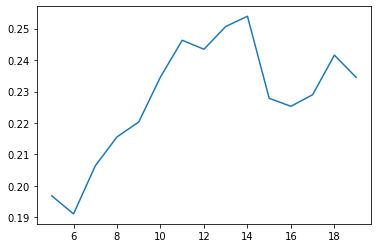

In [46]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
sil = []
kmsol = []
clus_vals = np.arange(5,20)
for k in clus_vals:
    #print(k)
    km = KMeans(n_clusters=k).fit(q)
    kmsol.append(km)
    labels = km.labels_
    sil.append(silhouette_score(q, labels, metric='euclidean'))

fig = plt.figure()
plt.plot(clus_vals,sil)

best_clustering = kmsol[np.argmax(sil)]
num_clusters = clus_vals[np.argmax(sil)]
q_clus = [q[np.where(best_clustering.labels_ == l )[0], :] for l in clus_vals]
t_clus = [t[np.where(best_clustering.labels_ == l )[0], :] for l in clus_vals]
idx_clus = [np.where(best_clustering.labels_ == l )[0] for l in clus_vals]


In [47]:
vgraph_clus = [vgraph_handle(qc) for qc in q_clus]
cliques_clusters = []
for ad in vgraph_clus:
    cliques = compute_greedy_clique_partition(ad.toarray(), min_cliuqe_size=14)
    cliques_clusters.append(cliques)

In [50]:
cliques_clusters_glob = []
for clus_idx, cliques in enumerate(cliques_clusters):
    #print(clus_idx)
    #print(len(idx_clus[clus_idx]))
    #print(np.max(cliques))
    for c in cliques:
        #print(c)
        if len(c):
            cliques_clusters_glob.append(idx_clus[clus_idx][c])

In [52]:
from visibility_utils import generate_distinct_colors
cols = generate_distinct_colors(len(cliques_clusters_glob), rgb = True)
cols = [list(c)+[1] for c in cols]

for id, c in enumerate(cliques_clusters_glob):
    plot_points(meshcat, t[c], f"ccl{id}", size = 0.01, color=Rgba(*cols[id]))

In [57]:
clique_idx = 0
for clique_idx in range(len(cliques_clusters_glob)):
    for idx in range(len(cliques_clusters_glob)):
        meshcat.SetProperty(f"/drake/ccl{idx}", "visible", False)
    meshcat.SetProperty(f"/drake/ccl{clique_idx}", "visible", True)
        
    cliques_vis = cliques_clusters_glob[clique_idx]
    start = q[cliques_vis[0]]
    target = q[cliques_vis[np.random.randint(len(cliques_vis))]]
    for i in range(10):
        wpd = densify_waypoints([start, target], 50)
        print(f"norm {np.linalg.norm(start-target)}")
        plot_endeff_traj(wpd, 'p', cols[clique_idx])
        for qa in wpd:
            showres(qa)
            #diagram_context.SetTime(cur_time)
            # if col_func_handle(qa):
            #     print('col')
            # cur_time+=frame_time
            time.sleep(0.01)
        meshcat.Delete('/iris/points/traj')
        start = target
        target = q[cliques_vis[np.random.randint(len(cliques_vis))]]

norm 4.817238489175589
norm 3.6253770527295943
norm 0.0
norm 0.7658711592865077
norm 0.0
norm 2.0388676672145136
norm 0.8067569797744668
norm 0.8067569797744668
norm 0.0
norm 1.6636091669606334
norm 0.0
norm 3.7598479734820853
norm 3.7598479734820853
norm 3.1704185496772688
norm 1.5037973287567017
norm 0.7644271880135645
norm 1.5138848620181602
norm 3.0929472306164634
norm 2.940162834732387
norm 0.0
norm 1.2264672365778782
norm 0.7412926559489568
norm 0.7412926559489568
norm 0.7844694303097612
norm 0.8445736009816552
norm 1.2952335604516512
norm 1.9106358302744815
norm 1.8561726309363284
norm 0.33085273888209354
norm 1.947846370929725
norm 0.0
norm 1.7340752643973552
norm 1.68880224200026
norm 1.68880224200026
norm 1.7679942038598615
norm 1.2646739595721
norm 1.1154869719327538
norm 1.3382441074155897
norm 2.006469794809785
norm 2.096408510738067
norm 0.5415085411453224
norm 0.5415085411453224
norm 0.6871941013909834
norm 0.0
norm 0.2100127656273558
norm 0.7505064502623411
norm 0.40540

In [21]:
all_clus_cliques = []
for c in clique_points_clus:
    all_clus_cliques+=c

In [22]:
from visibility_utils import get_coverage_estimator, get_sample_cfree_handle, get_col_func
from clique_covers import get_iris_metrics
from region_generation import SNOPT_IRIS_ellipsoid_parallel

q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1
col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 2.e-3
termination_threshold = -1
num_collision_infeasible_samples = 15
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = None, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)

In [23]:
if f"regions_red_{Npts}.pkl" in os.listdir('tmp'):
    with open(f"tmp/regions_red_{Npts}.pkl", 'rb') as f:
        regions_red = pickle.load(f)
else:
    seed_points, metrics, _ = get_iris_metrics([q[c] for c in cliques_red], col_func_handle_)
    regions_red, succs_sp, is_full = iris_handle(seed_points, metrics, [])
    with open(f"tmp/regions_red_{Npts}.pkl", 'wb') as f:
        pickle.dump(regions_red, f)

In [24]:

if f"regions_clus_cl_{Npts}.pkl" in os.listdir('tmp'):
    with open(f"tmp/regions_clus_cl_{Npts}.pkl", 'rb') as f:
        regions_clus = pickle.load(f)
else:
    seed_points, metrics, _ = get_iris_metrics(all_clus_cliques, col_func_handle_)
    regions_clus, succs_sp, is_full = iris_handle(seed_points, metrics, [])
    with open(f"tmp/regions_clus_cl_{Npts}.pkl", 'wb') as f:
        pickle.dump(regions_clus, f)

In [25]:

from utils import load_regions_from_experiment_dir

regions_c = load_regions_from_experiment_dir(
                    'logs/experiment_7dof_iiwa_bins_1_1500_0.300greedy20231018120325')

In [26]:
regions = regions_c + regions_clus

In [24]:
from visibility_utils import point_in_regions
inreg = []
for tpt, pt in zip(t,q):
    if point_in_regions(pt, regions):
        inreg.append(tpt)

plot_points(meshcat, np.array(inreg), 'inregions', size = 0.01, color = Rgba(0,1,0,1))

In [25]:
plot_points(meshcat, t, 'samples', size=0.005)

Text(0.5, 1.0, 'connectivity')

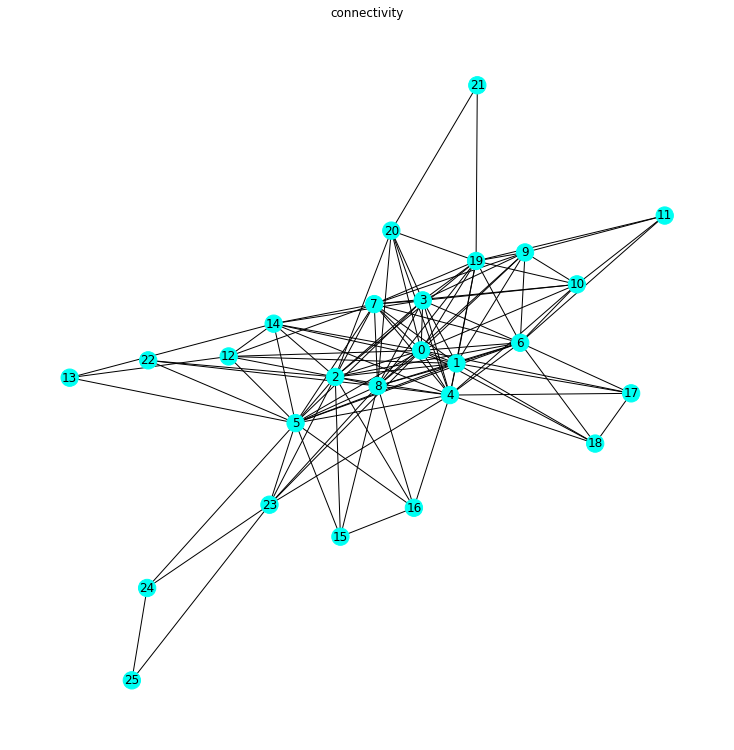

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

regs = regions
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [41]:
def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(12)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

In [42]:
def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(12)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [57]:
clique_idx = 0
for clique_idx in range(len(cliques)):
    for idx in range(len(cliques)):
        meshcat.SetProperty(f"/drake/c{idx}", "visible", False)
    meshcat.SetProperty(f"/drake/c{clique_idx}", "visible", True)
        
    cliques_vis = cliques[clique_idx]
    start = q[cliques_vis[0]]
    target = q[cliques_vis[np.random.randint(len(cliques_vis))]]
    for i in range(10):
        wpd = densify_waypoints([start, target], 50)
        plot_endeff_traj(wpd, 'p', cols[clique_idx])
        for qa in wpd:
            showres(qa)
            #diagram_context.SetTime(cur_time)
            # if col_func_handle(qa):
            #     print('col')
            # cur_time+=frame_time
            time.sleep(0.006)
        meshcat.Delete('/iris/points/traj')
        start = target
        target = q[cliques_vis[np.random.randint(len(cliques_vis))]]

KeyboardInterrupt: 

In [58]:
reg_of_interest = regions[6]
q_r = VPolytope(reg_of_interest).vertices().T

IndexError: list index out of range

In [40]:
plant.GetBodyByName("body")

<RigidBody name='body' index=12 model_instance=3>

In [34]:


# Example usage
hex_color = "#FFA500"  # Example hex color code (Orange)
red, green, blue = hex_to_rgb(hex_color)
print(f"RGB: ({red}, {green}, {blue})")

RGB: (1.0, 0.6470588235294118, 0.0)


In [14]:
ik = InverseKinematics(plant, plant_context)

In [14]:
import pickle

In [12]:
q, t, _ = sample_handle_ts(300, [])

100%|██████████| 300/300 [03:44<00:00,  1.34it/s]


In [13]:
plot_points(meshcat, t, 'a', size = 0.01)

In [14]:
# import time
# for pt in q:
#     showres(pt)
#     time.sleep(0.2)

In [15]:
from utils import load_regions_from_experiment_dir

regions = load_regions_from_experiment_dir(
                    'logs/experiment_7dof_iiwa_bins_taskspace_1_1000_0.600greedy20231019114035')

In [16]:
with open('test.pkl', 'wb') as f:
    pickle.dump(regions, f)

In [17]:
from visibility_utils import point_in_regions
in_regs = []
in_regs_t = []
out_regs = []
out_regs_t = []
for tpt, pt in zip(t,q):
    if point_in_regions(pt, regions):
        in_regs.append(pt)
        in_regs_t.append(tpt)
    else:
        out_regs.append(pt)
        out_regs_t.append(tpt)

In [18]:
plot_points(meshcat, np.array(in_regs_t), 'in_regions', size=0.03, color=Rgba(0,1,0,1))

In [ ]:
len(out_regs)

300

In [17]:
for r in regions:
    qv =VPolytope(r).vertices().T
    print('r')
    for q in qv[::100]:
        showres(q)
        time.sleep(0.001)

r
r
r
r


In [18]:
qv.shape

(160420, 7)

In [18]:
import time
for pt in in_regs:
    showres(pt)
    time.sleep(0.2)

In [12]:
seed = 1
N = 1500
eps = 0.3
ts_fraction = 0.1
max_iterations_clique = 10
min_clique_size = 20
approach = 1
ap_names = ['redu', 'greedy', 'nx', 'cvxh', 'cvxh_ell']
extend_cliques = False

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 2.e-3
termination_threshold = -1
num_collision_infeasible_samples = 15
relative_termination_threshold = 0.02

pts_coverage_estimator = 5000
cfg = {'seed': seed,
        'N': N,
        'eps': eps,
        'use_ts': True,
        'ts_fraction': ts_fraction,
        'max_iterations_clique': max_iterations_clique,
        'min_clique_size': min_clique_size,
        'approach': approach,
        'extend_cliques': extend_cliques,
        'require_sample_point_is_contained':require_sample_point_is_contained,
        'iteration_limit': iteration_limit,
        'configuration_space_margin':configuration_space_margin,
        'termination_threshold':termination_threshold,
        'num_collision_infeasible_samples':num_collision_infeasible_samples,
        'relative_termination_threshold':relative_termination_threshold,
        'pts_coverage_estimator':pts_coverage_estimator}

In [13]:
from visibility_utils import (get_col_func, 
                              get_sample_cfree_handle,
                              get_coverage_estimator,
                              vgraph)
from region_generation import SNOPT_IRIS_ellipsoid_parallel
from pydrake.all import SceneGraphCollisionChecker
from visibility_logging import CliqueApproachLogger
from visibility_clique_decomposition import VisCliqueInflation

In [14]:
q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)
estimate_coverage = get_coverage_estimator(sample_cfree, pts = pts_coverage_estimator)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold
robot_instances = [plant.GetModelInstanceByName("iiwa"), plant.GetModelInstanceByName("wsg")]

checker = SceneGraphCollisionChecker(model = diagram.Clone(), 
                    robot_model_instances = robot_instances,
                    distance_function_weights =  [1] * plant.num_positions(),
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.125)

def sample_handle_joint(N, M, regions, frac_ts_samples = ts_fraction, collision_free=True):
    N_ts = int(frac_ts_samples*N)
    N_c = N-N_ts
    pts_q_ts, pts_t, is_full_ts = sample_handle_ts(N_ts, regions, collision_free=collision_free)
    pts_q_c, is_full = sample_cfree(N_c, M, regions)
    return np.concatenate((pts_q_ts, pts_q_c), axis=0), is_full

vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 


INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


In [15]:
clogger = CliqueApproachLogger(f"7dof_iiwa_bins",f"{ap_names[approach]}", estimate_coverage=estimate_coverage, cfg_dict=cfg)
iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = clogger, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1- eps)

vcd = VisCliqueInflation(N, 
                    eps,
                    max_iterations=max_iterations_clique,
                    sample_cfree = sample_handle_joint,
                    col_handle= col_func_handle_,
                    build_vgraph=vgraph_handle,
                    iris_w_obstacles=iris_handle,
                    verbose = True,
                    logger=clogger,
                    approach=approach,
                    extend_cliques=extend_cliques,
                    min_clique_size = min_clique_size
                    )
regs = vcd.run()

logdir created
[16:03:25] [VisCliqueDecomp] Attempting to cover 70.0 '%' of Cfree 


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


[16:06:21] [VisCliqueDecomp] Found  9  cliques


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against shelves::top has already required 150 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 161 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 150 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 157 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 150 counter-example searches; st

[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


INFO:drake: Checking wsg::collision against shelves::top has already required 150 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 169 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 1


INFO:drake: Checking wsg::collision against shelves::top has already required 150 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 151 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 1


INFO:drake: Checking wsg::collision against binR::left has already required 150 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::left after 165 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


100%|██████████| 150/150 [00:21<00:00,  6.95it/s]


(100, 7)

In [17]:
pts_q, pts_t, _ = sample_handle_ts(100,[])
plot_points(meshcat, pts_t.squeeze(), 'tspts', size=0.01)

100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


In [32]:
from dijkstraspp import DijkstraSPPsolver
def dm(q):
    return q
dspp = DijkstraSPPsolver(regions, dm)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 107
[DijkstraSPP] Pre-Building adjacency matrix  10 / 107
[DijkstraSPP] Pre-Building adjacency matrix  20 / 107
[DijkstraSPP] Pre-Building adjacency matrix  30 / 107
[DijkstraSPP] Pre-Building adjacency matrix  40 / 107
[DijkstraSPP] Pre-Building adjacency matrix  50 / 107
[DijkstraSPP] Pre-Building adjacency matrix  60 / 107
[DijkstraSPP] Pre-Building adjacency matrix  70 / 107
[DijkstraSPP] Pre-Building adjacency matrix  80 / 107
[DijkstraSPP] Pre-Building adjacency matrix  90 / 107
[DijkstraSPP] Pre-Building adjacency matrix  100 / 107
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 5420
[DijkstraSPP] Pre-Building d-adjacency matrix  1000 / 5420
[DijkstraSPP] Pre-Building d-adjacency matrix  2000 / 5420
[DijkstraSPP] Pre-Building d-adjacency matrix  3000 / 5420
[DijkstraSPP] Pre-Building d-adjacency matrix  4000 / 5420


In [ ]:
import pickle
with open('dspp_bins_gcs.pkl', 'wb') as f:
    pickle.dump(dspp)

In [31]:
import time
for pt in q:
    showres(pt)
    time.sleep(0.01)

In [17]:
for i, v in enumerate(vp):
    plot_points(meshcat, v.vertices().T, f"vp{i}")

In [74]:
ids = Inspector.GetGeometries(binL_body)
shapes = [Inspector.GetShape(id) for id in ids]

BodyIndex(15)

In [78]:
from pydrake.all import PolygonSurfaceMesh

In [66]:
plant.GetBodyByName('shelves_body', plant.GetModelInstanceByName('shelves'))
plant.GetBodyByName('top_and_bottom', plant.GetModelInstanceByName('shelves'))


<RigidBody name='top_and_bottom' index=16 model_instance=4>

In [46]:
Inspector.GetFrameId()

TypeError: GetFrameId(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.geometry.SceneGraphInspector, geometry_id: pydrake.geometry.GeometryId) -> pydrake.geometry.FrameId

Invoked with: <pydrake.geometry.SceneGraphInspector object at 0x7f524109b770>

In [31]:
from pydrake.all import GlobalInverseKinematics

In [51]:
Inspector.Get()

TypeError: GetGeometryIdByName(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.geometry.SceneGraphInspector, frame_id: pydrake.geometry.FrameId, role: pydrake.geometry.Role, name: str) -> pydrake.geometry.GeometryId

Invoked with: <pydrake.geometry.SceneGraphInspector object at 0x7f524109b770>

In [17]:
g_ik = GlobalInverseKinematics(plant)

In [22]:
g_ik.AddWorldPositionConstraint(plant.GetBodyByName('base').index(), 
                                np.zeros(3),
                                tf.translation()-0.05,
                                tf.translation()+0.05,)

NameError: name 'tf' is not defined

In [ ]:
def get_gik_problem_solver(plant_ik, plant_context_ik, body_indices, collision_free= False):
    def solve_gik_problem(poses, q0, collision_free = collision_free):
        q_min = plant.GetPositionLowerLimits()
        q_max = plant.GetPositionUpperLimits()
        q_diff =  q_max-q_min
        gik = GlobalInverseKinematics(plant_ik)
        #GlobalInverseKinematics(plant_ik) #InverseKinematics(plant_ik, plant_context_ik)
    
        for pose, b in zip(poses, body_indices):
            gik.AddWorldPositionConstraint(
                b,
                np.zeros(3),
                plant_ik.world_frame(),
                pose.translation()-0.05,
                pose.translation()+0.05,
            )
            # ik.AddWorldPositionConstraint(plant.GetBodyByName('ur_tool0').index(), 
            #                               pose.translation(),
            #                               pose.translation()-0.05,
            #                               pose.translation()+0.05)
            gik.AddOrientationConstraint(
                f,
                RotationMatrix(),
                plant_ik.world_frame(),
                pose.rotation(),
                0.01,
            )
        prog = ik.get_mutable_prog()
        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
        prog.SetInitialGuess(q, q0)
        result = Solve(ik.prog())
        if result.is_success():
                return result.GetSolution(q)
        return None
    return solve_ik_problem

In [18]:
dir(g_ik)

['AddPostureCost',
 'AddWorldOrientationConstraint',
 'AddWorldPositionConstraint',
 'AddWorldRelativePositionConstraint',
 'Options',
 'ReconstructGeneralizedPositionSolution',
 'SetInitialGuess',
 '__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_del_orig',
 'body_position',
 'body_rotation_matrix',
 'get_mutable_prog',
 'prog']

In [27]:
GlobalInverseKinematics.Options()

GlobalInverseKinematics.Options(num_intervals_per_half_axis=2, approach=Approach.kBilinearMcCormick, interval_binning=IntervalBinning.kLogarithmic, linear_constraint_only=False)

FloatSlider(value=0.0, description='x', max=1.0, min=-0.5)

FloatSlider(value=0.0, description='y', max=0.5, min=-0.5)

FloatSlider(value=0.01, description='z', max=1.0, min=0.01)

FloatSlider(value=0.0, description='rx', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='ry', max=3.141592653589793, min=-3.141592653589793)

FloatSlider(value=0.0, description='rz', max=3.141592653589793, min=-3.141592653589793)

In [ ]:
# start = np.array([-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
#         0.74567])
# end = np.array([ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
#         0.24567])

poi =np.array([
    #[-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
     #   0.74567],
        [ 1.83294, -0.0944 , -0.06706, -1.2944 ,  1.53294,  1.4056 ,
        0.34567],
        [ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
        0.24567],
        [ 1.23294, -0.1944 ,  0.     ,  1.1056 ,  1.43294,  1.1056 ,
       -0.15433],
       [ 1.23294, -0.4944 , -0.06706,  2.0056 ,  1.23294,  1.3056 ,
        0.94567],
        
        [ 1.83294,  0.3056 , -0.06706, -1.3944 ,  1.53294,  1.4056 ,
       -0.05433],
       [ 1.63294,  0.7056 ,  0.23294, -1.6944 ,  1.53294,  1.2056 ,
       -0.65433]])
showres(poi[0])

In [ ]:
import os 
'experiment_7dof_iiwa__1_1500_0.300greedy20230908201834' in os.listdir('logs')

In [ ]:
import pickle
path = 'logs_icra_paper/experiment_7dof_iiwa__1_1500_0.300greedy20230908201834'
with open(path+'/data/it_2.pkl', 'rb') as f:
    data = pickle.load(f)

regions = []
for ga,gb in zip(data['ra'], data['rb']):
    for a,b in zip(ga,gb):
        regions.append(HPolyhedron(a,b))
regions = regions[:43]

In [ ]:
from visibility_utils import point_in_regions
for p in poi:
    print(point_in_regions(p, regions))

In [ ]:
from region_generation import SNOPT_IRIS_obstacles
def estimate_coverage(r):
    return 0
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 6
snopt_iris_options.configuration_space_margin = 2e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 15
snopt_iris_options.relative_termination_threshold = 0.02

iris_handle = partial(SNOPT_IRIS_obstacles, 
                        logger = None, 
                        plant = plant, 
                        context = diagram_context,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)


showres(poi[4,:])

# 213  054
seq = [2,1,3,5,4,0,2] 
# r_poi,_ = iris_handle(poi, [], [])
#r_poi = [r1[0],r2[0]]
# with open('rpoi_3shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in r_poi]
#     rb = [r.b() for r in r_poi]
#     pickle.dump([ra, rb], f)

In [ ]:
import pickle
with open('tmp/rpoi_3shelf.pkl', 'rb') as f:
    rpoilist = pickle.load(f)

r_poi = []
for ra, rb in zip(rpoilist[0], rpoilist[1]):
    r_poi.append(HPolyhedron(ra,rb))
    ra = [r.A() for r in r_poi]
    rb = [r.b() for r in r_poi]
    #pickle.dump([ra, rb], f)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors

regs = regions+r_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions, r_poi], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [ ]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions + r_poi, conversion_dummy)
# import pickle
# dsppname = "7dofnew_dspp_small.pkl"
# with open(dsppname, 'rb') as f:
#     dspp = pickle.load( f)
import pickle
dsppname = "tmp/7dofnew_dspp_small.pkl"
with open(dsppname, 'wb') as f:
    pickle.dump(dspp, f)

In [ ]:
colors = [(1,0,0,1),(1,1,0,1),
(0,1,0,1),
(0,1,1,1),
(0,0,1,1),
(1,0,1,1),
]

meshcat.Delete("/iris/points/traj/")
for idx,i in enumerate(seq[:-1]):
    wp, dist = dspp.solve(poi[i,:], poi[seq[idx+1],:], refine_path = True)
    wpd = densify_waypoints(wp)
    plot_endeff_traj(wpd, str(i), colors[i])




In [ ]:
from pydrake.all import Mesh
a = Mesh('display_signs/7dof_sign_arxiv.gltf')
meshcat.SetObject('/instructionsign', a)
meshcat.SetTransform('/instructionsign',RigidTransform(
                            RotationMatrix.MakeZRotation(-np.pi/2)@RotationMatrix.MakeXRotation(-np.pi/2), 
                            np.array([0, 10 , 0])))

In [ ]:
frame_time = 1/32.0
cur_time = 0
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)
meshcat.StartRecording()
animation = meshcat.get_mutable_recording()
for i in range(20):
    wp, dist = dspp.solve(poi[seq[(i)%len(seq)],:], poi[seq[(i+1)%len(seq)],:], refine_path = True)
    wpd = densify_waypoints(wp, 50)
    for qa in wpd:
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle(qa):
            print('col')
        cur_time+=frame_time
        time.sleep(frame_time)
meshcat.StopRecording()
animation.set_autoplay(True)
meshcat.PublishRecording()
with open("static_htmls/7DOF_IIWA_arxiv.html", "w+") as f:
    f.write(meshcat.StaticHtml())

In [ ]:
def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))